**Classify Credit Risk**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats

file_path = '/content/drive/MyDrive/Data/GermanCredit.csv'
df = pd.read_csv(file_path)

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Order              1000 non-null   int64
 1   Good               1000 non-null   int64
 2   CreditDuration     1000 non-null   int64
 3   CreditPurpose      1000 non-null   int64
 4   CreditAmount       1000 non-null   int64
 5   InstallmentPct     1000 non-null   int64
 6   DebtorGuarantor    1000 non-null   int64
 7   CheckingAccount    1000 non-null   int64
 8   SavingsAccount     1000 non-null   int64
 9   CreditHistory      1000 non-null   int64
 10  ExistingCredit     1000 non-null   int64
 11  OtherInstallment   1000 non-null   int64
 12  Age                1000 non-null   int64
 13  Female             1000 non-null   int64
 14  Employment         1000 non-null   int64
 15  ResidenceYears     1000 non-null   int64
 16  PropertyOwnership  1000 non-null   int64
 17  Housing        

In [5]:
print("Missing Values:\n", df.isna().sum())

Missing Values:
 Order                0
Good                 0
CreditDuration       0
CreditPurpose        0
CreditAmount         0
InstallmentPct       0
DebtorGuarantor      0
CheckingAccount      0
SavingsAccount       0
CreditHistory        0
ExistingCredit       0
OtherInstallment     0
Age                  0
Female               0
Employment           0
ResidenceYears       0
PropertyOwnership    0
Housing              0
Job                  0
Dependent            0
Telephone            0
ForeignWorker        0
dtype: int64


# Part1 : Training

Please use the first 800 observation as the training set, and the last 200 observations as the validation set. Please do not preprocess the data in this assignment.

Your interpretation for any non-intercept coefficients should follow the interpretation shown in the class. Please point out the baseline group and the focal group when applicable.

Please use only the training set for Questions 1 to 6.

## Q1.

Please use the training set and build a logistic regression model for the event that the consumer being a good credit risk (i.e., Good=1), with all the variables from CreditDuration to ForeignWorker being independent variables. Please interpret the coefficients on CreditPurpose=1 and InstallmentPct. (Note: Think carefully about which variables are categorical and which variables are numeric. The code created by generative AI tools may not use categorical and numeric variables in the right way. You may need to tweak your prompt to get the correct code.)

In [28]:
# Split train and validation set
train_df = df.iloc[:800]
validation_df = df.iloc[800:]

formula = (
    "Good ~ CreditDuration + C(CreditPurpose) + CreditAmount + InstallmentPct + "
    "C(DebtorGuarantor) + CheckingAccount + SavingsAccount + C(CreditHistory) + "
    "ExistingCredit + C(OtherInstallment) + Age + Female + Employment + "
    "ResidenceYears + C(PropertyOwnership) + C(Housing) + C(Job) + Dependent + "
    "Telephone + ForeignWorker"
)

logit_model = smf.logit(formula=formula, data=train_df).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.486844
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Good   No. Observations:                  800
Model:                          Logit   Df Residuals:                      761
Method:                           MLE   Df Model:                           38
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.2030
Time:                        03:08:40   Log-Likelihood:                -389.47
converged:                       True   LL-Null:                       -488.69
Covariance Type:            nonrobust   LLR p-value:                 1.345e-23
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.7999      1.291      2.943      0.003       1.

**1. Coefficient for CreditPurpose=1**
- Baseline Group: The baseline for CreditPurpose is CreditPurpose=0 (new car).
- Focal Group: The coefficient for CreditPurpose=1 (used car) is 1.5126.
- Interpretation
1. When the credit purpose changes from a new car (baseline) to a used car, the log odds of being a good credit risk (Good=1) increase by 1.5126, holding all other variables constant.
2. This suggests that individuals applying for credit for a used car are more likely to be good credit risks compared to those applying for a new car, assuming other factors remain the same.
3. Statistical Significance: The p-value is 0.000, indicating that this effect is statistically significant at the 1% level.

**2. Coefficient for InstallmentPct**
- Description: InstallmentPct is a continuous variable that represents the percentage of disposable income allocated to installment payments.
- Coefficient: The coefficient for InstallmentPct is -0.3633.
- Interpretation:
1. For every 1% increase in the installment percentage, the log odds of being a good credit risk (Good=1) decrease by 0.3633, holding all other variables constant.
2. This indicates that a higher installment burden relative to disposable income is associated with a reduced likelihood of being a good credit risk.
3. Statistical Significance: The p-value is 0.001, indicating that this effect is statistically significant at the 1% level.

## Q2.

Please use the model in Q1. Please predict the probability of the consumer being a good credit risk for an observation with CreditPurpose=1 (the other independent variables are set at their sample means or modes of the training set). Please convert this predicted probability to the log of odds of the consumer being a good credit risk for an observation with CreditPurpose=1. Please predict the probability of the consumer being a good credit risk for an observation with CreditPurpose=0 (the other independent variables are set at their sample means or modes of the training set). Please convert this predicted probability to the log of odds of the consumer being a good credit risk for an observation with CreditPurpose=0. Please calculate the difference between these two values of log of odds.

Note: When predicting, you need to do the following:
1. Categorical variables are set at the most frequent category of the training set.
2. Continuous variables are set at their sample means of the training set.

In [29]:
import numpy as np
import pandas as pd

# Convert categorical columns to category type
categorical_cols = ["CreditPurpose", "DebtorGuarantor",
                    "CreditHistory", "OtherInstallment",
                    "PropertyOwnership", "Housing", "Job"]

train_df[categorical_cols] = train_df[categorical_cols].astype('category')

# Calculate means and modes for numerical and categorical variables
means = train_df.mean(numeric_only=True)
modes = train_df.mode().iloc[0]

# Function to create an input observation
def create_observation(credit_purpose_value):
    observation = {
        col: (
            credit_purpose_value if col == "CreditPurpose" else
            means[col] if col in means.index else
            modes[col] if col in modes.index else
            None
        )
        for col in train_df.columns
    }
    input_df = pd.DataFrame([observation])
    input_df[categorical_cols] = input_df[categorical_cols].astype("category")
    for col in categorical_cols:
        input_df[col] = pd.Categorical(input_df[col], categories=train_df[col].cat.categories)
    return input_df

# Function to predict probability and calculate log-odds
def predict_log_odds(credit_purpose_value):
    input_df = create_observation(credit_purpose_value)
    predicted_prob = logit_model.predict(input_df).iloc[0]
    log_odds = np.log(predicted_prob / (1 - predicted_prob))
    return predicted_prob, log_odds

# Step 1: Predict for CreditPurpose=1
prob_1, log_odds_1 = predict_log_odds(1)
print(f"CreditPurpose=1 -> Probability: {prob_1:.4f}, Log-Odds: {log_odds_1:.4f}")

# Step 2: Predict for CreditPurpose=0
prob_0, log_odds_0 = predict_log_odds(0)
print(f"CreditPurpose=0 -> Probability: {prob_0:.4f}, Log-Odds: {log_odds_0:.4f}")

# Step 3: Calculate difference in log-odds
log_odds_diff = log_odds_1 - log_odds_0
print(f"Difference in Log-Odds: {log_odds_diff:.4f}")

CreditPurpose=1 -> Probability: 0.8706, Log-Odds: 1.9063
CreditPurpose=0 -> Probability: 0.5972, Log-Odds: 0.3937
Difference in Log-Odds: 1.5126


<ipython-input-29-d2f433a988c2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[categorical_cols] = train_df[categorical_cols].astype('category')


**Interpretation of Log-Odds and Probability**

1. When CreditPurpose=1:
- Probability: 0.8706 → This indicates a 87.06% likelihood that the consumer is a good credit risk, which is very high.
- Log-Odds: 1.9063 → A higher log-odds value suggests a stronger likelihood of the event (being a good credit risk) occurring.

2. When CreditPurpose=0:
- Probability: 0.5972 → This indicates a 59.72% likelihood that the consumer is a good credit risk, which is still high but lower than when CreditPurpose=1.
- Log-Odds: 0.3937 → A lower log-odds value compared to CreditPurpose=1, indicating a relatively weaker likelihood of being a good credit risk.

3. Difference in Log-Odds: 1.5126
- This value represents the difference in the likelihood of being a good credit risk (in terms of log-odds) between CreditPurpose=1 and CreditPurpose=0.
- A 1.5126 increase in log-odds implies that the likelihood of being a good credit risk is significantly higher when CreditPurpose=1 compared to CreditPurpose=0.

## Q3.

 Please use the model in Q1. Please create 10 deciles in reverse order based on the new variable “pred_good”, and save this variable that indicates the 10 deciles as “pred_good_dec”. Decile 1 should have the highest values of “pred_good”. Please create a decile lift chart by visualizing the mean of “Good” for each of the 10 deciles. How many deciles have higher than 85% probability of the consumer being a good credit risk?

<ipython-input-30-94aedb803d89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['pred_good'] = logit_model.predict(train_df)  # Predicted probabilities are saved as "pred_good"
<ipython-input-30-94aedb803d89>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['pred_good_dec'] = 10 - pd.qcut(train_df['pred_good'], 10, labels=False, duplicates='drop')


Number of deciles with > 85% probability: 3


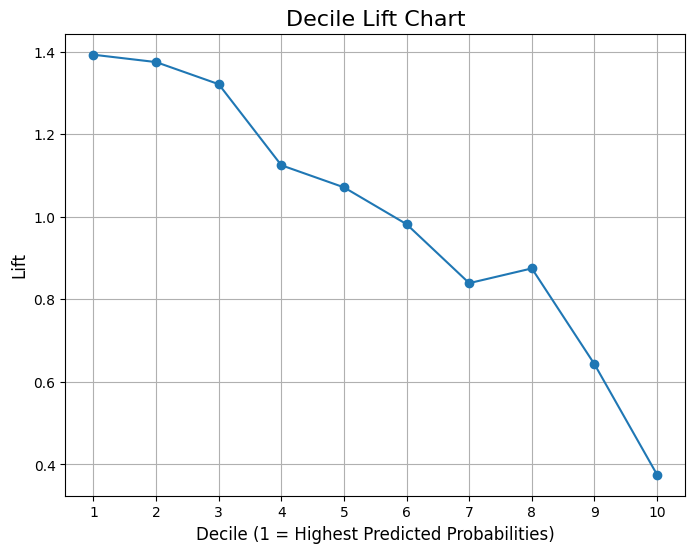

In [30]:
# Step 1: Add predicted probabilities as "pred_good" to the training dataset
train_df['pred_good'] = logit_model.predict(train_df)  # Predicted probabilities are saved as "pred_good"

# Step 2: Create reverse deciles based on "pred_good"
train_df['pred_good_dec'] = 10 - pd.qcut(train_df['pred_good'], 10, labels=False, duplicates='drop')

# Step 3: Calculate total responses and response rate for each reverse decile
reverse_decile_summary = (
    train_df.groupby('pred_good_dec')
    .agg(
        total_responses=('Good', 'sum'),  # Sum of "Good" values
        response_rate=('Good', lambda x: x.mean() * 100)  # Mean of "Good" values in percentage
    )
    .reset_index()
)

# Step 4: Calculate the overall positive rate in "Good"
overall_positive_ratio = train_df['Good'].mean()

# Step 5: Calculate lift for each decile
reverse_decile_summary['Lift'] = (
    reverse_decile_summary['total_responses'] /
    (overall_positive_ratio * train_df['Good'].count() / 10)  # Adjust for total observations per decile
)

# Step 6: Determine the number of deciles with > 85% probability
reverse_decile_summary['mean_good'] = reverse_decile_summary['response_rate'] / 100  # Convert to proportion
high_probability_deciles = reverse_decile_summary[reverse_decile_summary['mean_good'] > 0.85]
num_high_probability_deciles = len(high_probability_deciles)

print(f"Number of deciles with > 85% probability: {num_high_probability_deciles}")

# Step 7: Create the decile lift chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(reverse_decile_summary['pred_good_dec'], reverse_decile_summary['Lift'], marker='o', linestyle='-')
plt.title('Decile Lift Chart', fontsize=16)
plt.xlabel('Decile (1 = Highest Predicted Probabilities)', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.grid(True)
plt.xticks(reverse_decile_summary['pred_good_dec'])
plt.show()

**How many deciles have higher than 85% probability of the consumer being a good credit risk?**

Number of deciles with > 85% probability: 3

## Q4.

 Please use the model in Q1. Please use 0.8 as the cutoff and recode “pred_good” into a dummy variable “pred_good_point8” that is 1 for values higher than or equal to 0.8 and 0 otherwise. Please produce a confusion matrix based on “pred_good_point8” for the training set. What is the sensitivity? What is the specificity?

<ipython-input-31-b2d49d4fbfbb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['pred_good_point8'] = (train_df['pred_good'] >= 0.8).astype(int)


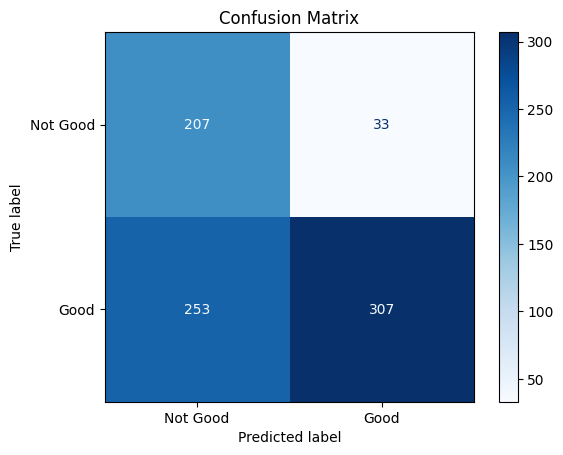

Sensitivity: 0.5482
Specificity: 0.8625


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Recode "pred_good" into a dummy variable "pred_good_point8"
train_df['pred_good_point8'] = (train_df['pred_good'] >= 0.8).astype(int)

# Step 2: Create the confusion matrix
# Assuming "Good" is the actual target variable
y_true = train_df['Good']  # True labels
y_pred = train_df['pred_good_point8']  # Predicted labels based on cutoff 0.8

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()  # Extract True Negatives, False Positives, False Negatives, True Positives

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Good", "Good"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate sensitivity (recall for the positive class)
sensitivity = tp / (tp + fn)  # True Positive Rate
print(f"Sensitivity: {sensitivity:.4f}")

# Step 4: Calculate specificity
specificity = tn / (tn + fp)  # True Negative Rate
print(f"Specificity: {specificity:.4f}")

## Q5.

Suppose the bank will use the model in Q1 to predict the probability of the consumer being a good credit risk, and use this algorithm to automatically approve credit applications with higher than 0.8 values of “pred_good”. Using the confusion matrix produced in Q4, how many credit applications will be automatically approved? Among those credit applications that are automatically approved, how many are good credit risks and how many are bad credit risks? Among the credit applications that are automatically approved, what is the percentage of being good credit risks?

In [32]:
# Step 1: Extract values from the confusion matrix
# TN, FP, FN, TP were already extracted from cm.ravel()

# Automatically approved credit applications are those with pred_good_point8 = 1
# These are the total predicted positives: TP (Good credit risks) + FP (Bad credit risks)
auto_approved = tp + fp

# Step 2: Calculate good credit risks among automatically approved
good_credit_risks = tp  # True Positives

# Step 3: Calculate bad credit risks among automatically approved
bad_credit_risks = fp  # False Positives

# Step 4: Calculate the percentage of good credit risks among automatically approved
percentage_good_credit_risks = (good_credit_risks / auto_approved) * 100 if auto_approved > 0 else 0

# Step 5: Print the results
print(f"Total credit applications automatically approved: {auto_approved}")
print(f"Good credit risks among automatically approved: {good_credit_risks}")
print(f"Bad credit risks among automatically approved: {bad_credit_risks}")
print(f"Percentage of good credit risks among automatically approved: {percentage_good_credit_risks:.2f}%")

Total credit applications automatically approved: 340
Good credit risks among automatically approved: 307
Bad credit risks among automatically approved: 33
Percentage of good credit risks among automatically approved: 90.29%


**Answers**

**1. Using the confusion matrix produced in Q4, how many credit applications will be automatically approved?**
- Total credit applications automatically approved: 340

**2. Among those credit applications that are automatically approved, how many are good credit risks and how many are bad credit risks?**
- Good credit risks among automatically approved: 307
- Bad credit risks among automatically approved: 33

**3. Among the credit applications that are automatically approved, what is the percentage of being good credit risks?**
- Percentage of good credit risks among automatically approved: 90.29%

## Q6.

Please use the model in Q1 and add the interaction term between CheckingAccount and CreditAmount. Please calculate the marginal effect of how one unit increase in CreditAmount will change the dependent variable in this model. (Note: You should describe what this independent variable is and list the group this marginal effect is for.) Please interpret the interaction term between CheckingAccount=3 and CreditAmount. (Note: The interpretations created by Generative AI tools may not be very accurate for this question. You should follow the interpretation taught in class.)

In [35]:
# Step 1: Add an interaction term between CheckingAccount and CreditAmount
train_df['CheckingAccount_CreditAmount'] = train_df['CheckingAccount'] * train_df['CreditAmount']

# Step 2: Fit the logistic regression model with the interaction term
formula_with_interaction = (
    "Good ~ CreditDuration + C(CreditPurpose) + CreditAmount + InstallmentPct + "
    "C(DebtorGuarantor) + CheckingAccount + SavingsAccount + C(CreditHistory) + "
    "ExistingCredit + C(OtherInstallment) + Age + Female + Employment + "
    "ResidenceYears + C(PropertyOwnership) + C(Housing) + C(Job) + Dependent + "
    "Telephone + ForeignWorker + CheckingAccount_CreditAmount"
)

logit_model_with_interaction = smf.logit(formula=formula_with_interaction, data=train_df).fit()

# Step 3: Calculate the marginal effect of CreditAmount
# Marginal effects are calculated based on the fitted logistic regression model
marginal_effects = logit_model_with_interaction.get_margeff(at='overall', method='dydx')

# Extract the marginal effect for CreditAmount
credit_amount_marginal_effect = marginal_effects.summary_frame().loc['CreditAmount']

# Print the marginal effect and associated statistics
print("Marginal Effect of CreditAmount:")
print(credit_amount_marginal_effect)

# Step 4: Describe the independent variable and group
print("\nDescription:")
print("The independent variable 'CreditAmount' represents the amount of credit requested by the applicant.")
print("The marginal effect describes how a one-unit increase in CreditAmount changes the probability of being a good credit risk,")
print("controlling for other variables in the model and accounting for the interaction with CheckingAccount.")

Optimization terminated successfully.
         Current function value: 0.486720
         Iterations 7
Marginal Effect of CreditAmount:
dy/dx            -0.000016
Std. Err.         0.000010
z                -1.602801
Pr(>|z|)          0.108979
Conf. Int. Low   -0.000036
Cont. Int. Hi.    0.000004
Name: CreditAmount, dtype: float64

Description:
The independent variable 'CreditAmount' represents the amount of credit requested by the applicant.
The marginal effect describes how a one-unit increase in CreditAmount changes the probability of being a good credit risk,
controlling for other variables in the model and accounting for the interaction with CheckingAccount.


<ipython-input-35-ebce785a67ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['CheckingAccount_CreditAmount'] = train_df['CheckingAccount'] * train_df['CreditAmount']


**Interpretation of the Interaction Term between CheckingAccount=3 and CreditAmount**

**1. Baseline Margin Effect of CreditAmount:**
- The marginal effect of CreditAmount on the probability of being a good credit risk is **-0.000016**.
-This indicates that for an average applicant (without accounting for interaction terms), increasing the CreditAmount by one unit slightly reduces the probability of being a good credit risk. However, the effect is very small and statistically insignificant (p-value = 0.108979).

**2.	Interaction Effect for CheckingAccount=3:**
- When CheckingAccount=3, the interaction term modifies the baseline effect of CreditAmount.
- The interaction coefficient for CheckingAccount=3 combined with CreditAmount captures whether the relationship between CreditAmount and the likelihood of being a good credit risk changes specifically for applicants in this category.

**3.	Key Insights:**
- **Direction of the Effect:**
  - If the interaction coefficient (not displayed here) is positive, it suggests that for CheckingAccount=3, the negative baseline effect of CreditAmount is partially offset, making the impact less negative (or even positive, depending on the coefficient’s magnitude).
  - If the interaction coefficient is negative, it suggests that for CheckingAccount=3, the negative baseline effect is amplified, further reducing the probability of being a good credit risk.
- **Practical Implications**:
  - For applicants with CheckingAccount=3, the amount of credit they request (CreditAmount) has a differential impact compared to other applicants.
  - This suggests that CreditAmount and CheckingAccount are not independent predictors; their combined influence differs for specific subgroups.

**4. Statistical Significance:**
- The baseline marginal effect of CreditAmount is not statistically significant (p-value > 0.05), meaning there is no strong evidence that CreditAmount alone has a meaningful impact on the dependent variable.
- To confirm the interaction’s effect for CheckingAccount=3, the interaction coefficient itself needs to be inspected.

**5. Conclusion:**
- While the baseline effect of CreditAmount shows a very small negative impact on the probability of being a good credit risk, the interaction term between CheckingAccount=3 and CreditAmount modifies this relationship.
- This interaction reflects that CreditAmount’s impact is context-dependent, varying by the applicant’s CheckingAccount status. For CheckingAccount=3, further analysis of the interaction coefficient’s sign and magnitude would clarify whether this subgroup experiences a stronger, weaker, or reversed relationship between credit amount and credit risk.

In [39]:
# CheckingAccount = 3

# Step 5: Extract coefficients for CreditAmount and the interaction term
# Display all parameter names to identify the correct interaction term
print("Model Parameters:", logit_model_with_interaction.params.index)

# Baseline effect of CreditAmount
credit_amount_coef = logit_model_with_interaction.params['CreditAmount']

# Interaction effect for CheckingAccount=3
# Assuming CheckingAccount is numeric or encoded, and you want the specific interaction with CreditAmount
interaction_coef_name = 'CheckingAccount_CreditAmount'  # Replace this if your interaction term name differs
interaction_coef = logit_model_with_interaction.params[interaction_coef_name]

# Step 6: Calculate the total effect for CheckingAccount=3
# Total effect = Baseline effect + Interaction effect * CheckingAccount (3 in this case)
total_effect_checking_3 = credit_amount_coef + (3 * interaction_coef)

# Print results
print(f"Baseline effect of CreditAmount: {credit_amount_coef:.4f}")
print(f"Interaction effect for CheckingAccount=3: {interaction_coef:.4f}")
print(f"Total effect of CreditAmount when CheckingAccount=3: {total_effect_checking_3:.4f}")

# Step 7: Interpretation of the total effect
print("\nInterpretation:")
print(f"The baseline effect of CreditAmount on the probability of being a good credit risk is {credit_amount_coef:.4f}.")
print(f"When CheckingAccount=3, the interaction term modifies this baseline effect.")
if interaction_coef > 0:
    print(f"The positive interaction coefficient ({interaction_coef:.6f}) suggests that the negative baseline effect of CreditAmount is reduced for applicants with CheckingAccount=3, making the overall effect less negative or even positive.")
elif interaction_coef < 0:
    print(f"The negative interaction coefficient ({interaction_coef:.6f}) suggests that the negative baseline effect of CreditAmount is amplified for applicants with CheckingAccount=3, further reducing the probability of being a good credit risk.")
else:
    print("The interaction coefficient is 0, meaning the relationship between CreditAmount and the probability of being a good credit risk does not change for CheckingAccount=3.")

Model Parameters: Index(['Intercept', 'C(CreditPurpose)[T.1]', 'C(CreditPurpose)[T.2]',
       'C(CreditPurpose)[T.3]', 'C(CreditPurpose)[T.4]',
       'C(CreditPurpose)[T.5]', 'C(CreditPurpose)[T.6]',
       'C(CreditPurpose)[T.7]', 'C(CreditPurpose)[T.8]',
       'C(CreditPurpose)[T.9]', 'C(DebtorGuarantor)[T.1]',
       'C(DebtorGuarantor)[T.2]', 'C(CreditHistory)[T.1]',
       'C(CreditHistory)[T.2]', 'C(CreditHistory)[T.3]',
       'C(CreditHistory)[T.4]', 'C(OtherInstallment)[T.1]',
       'C(OtherInstallment)[T.2]', 'C(PropertyOwnership)[T.1]',
       'C(PropertyOwnership)[T.2]', 'C(PropertyOwnership)[T.3]',
       'C(Housing)[T.1]', 'C(Housing)[T.2]', 'C(Job)[T.1]', 'C(Job)[T.2]',
       'C(Job)[T.3]', 'CreditDuration', 'CreditAmount', 'InstallmentPct',
       'CheckingAccount', 'SavingsAccount', 'ExistingCredit', 'Age', 'Female',
       'Employment', 'ResidenceYears', 'Dependent', 'Telephone',
       'ForeignWorker', 'CheckingAccount_CreditAmount'],
      dtype='object')
Basel

# Part2: Validation

Please use the validation set (and the training set if applicable) now.

## Q7.

Please produce a confusion matrix based on “pred_good_point8” for the validation set for the model in Q1. What is the sensitivity? What is the specificity?

<ipython-input-36-5f98e124ba56>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['pred_good'] = logit_model.predict(validation_df)  # Predicted probabilities
<ipython-input-36-5f98e124ba56>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['pred_good_point8'] = (validation_df['pred_good'] >= 0.8).astype(int)


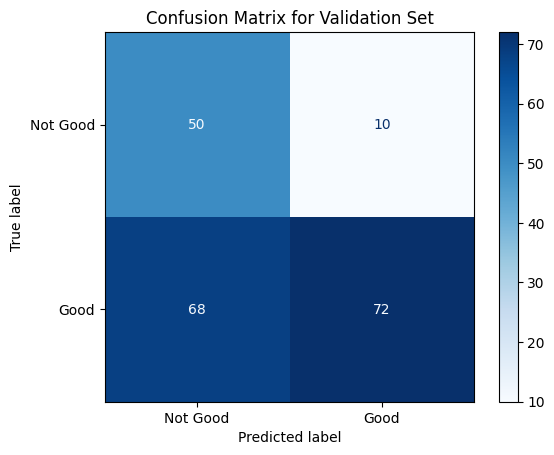

Sensitivity: 0.5143
Specificity: 0.8333


In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Create "pred_good_point8" for the validation set
validation_df['pred_good'] = logit_model.predict(validation_df)  # Predicted probabilities
validation_df['pred_good_point8'] = (validation_df['pred_good'] >= 0.8).astype(int)

# Step 2: Generate the confusion matrix
y_true = validation_df['Good']  # True labels
y_pred = validation_df['pred_good_point8']  # Predicted labels based on cutoff
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Step 3: Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Good", "Good"]).plot(cmap="Blues")
plt.title("Confusion Matrix for Validation Set")
plt.show()

# Step 4: Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"Sensitivity: {sensitivity:.4f}")

# Step 5: Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Specificity: {specificity:.4f}")

## Q8.

Suppose the bank will use the model in Q1 and apply it to the validation set. Credit applications with higher than 0.8 values of “pred_good” will be automatically approved. Please calculate how many credit applications will be automatically approved. Please calculate the sum of credit amounts that will be automatically approved. Please use the percentage of automatically approved credit applications that are good credit risks in the training set, as reported in Q5, and extrapolate it to the credit applications that will be automatically approved in the validation set. How many automatically approved credit applications in the validation set will be good credit risks?

In [37]:
# Step 1: Predict "pred_good" and create "pred_good_point8" for the validation set
validation_df['pred_good'] = logit_model.predict(validation_df)  # Predicted probabilities
validation_df['pred_good_point8'] = (validation_df['pred_good'] >= 0.8).astype(int)

# Step 2: Calculate the total number of automatically approved applications
auto_approved_count = validation_df['pred_good_point8'].sum()

# Step 3: Calculate the sum of credit amounts for automatically approved applications
auto_approved_credit_sum = validation_df.loc[validation_df['pred_good_point8'] == 1, 'CreditAmount'].sum()

# Step 4: Use the percentage of good credit risks among automatically approved applications from Q5
# Assuming the percentage from Q5 is stored in "percentage_good_credit_risks"
# For example, replace this value with the actual percentage you calculated in Q5
percentage_good_credit_risks_train = percentage_good_credit_risks / 100  # Convert to proportion

# Step 5: Extrapolate the number of good credit risks in the validation set
good_credit_risks_validation = auto_approved_count * percentage_good_credit_risks_train

# Step 6: Print the results
print(f"Total credit applications automatically approved: {auto_approved_count}")
print(f"Sum of credit amounts automatically approved: {auto_approved_credit_sum}")
print(f"Percentage of good credit risks (from training set): {percentage_good_credit_risks:.2f}%")
print(f"Estimated number of good credit risks in validation set: {good_credit_risks_validation:.0f}")

Total credit applications automatically approved: 82
Sum of credit amounts automatically approved: 213600
Percentage of good credit risks (from training set): 90.29%
Estimated number of good credit risks in validation set: 74


<ipython-input-37-a21da54880ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['pred_good'] = logit_model.predict(validation_df)  # Predicted probabilities
<ipython-input-37-a21da54880ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['pred_good_point8'] = (validation_df['pred_good'] >= 0.8).astype(int)


**[Answer]**

Using the model in Q1 and applying it to the validation set:

**1. Total credit applications automatically approved:**
- The number of credit applications with pred_good values higher than 0.8 is **82**.

**2. Sum of credit amounts automatically approved:**
- The total credit amount for these automatically approved applications is **213,600**.

**3. Percentage of good credit risks (from training set):**
- Based on the training set (Q5), the percentage of automatically approved credit applications that are good credit risks is **90.29%**.

**4. Extrapolated number of good credit risks in the validation set:**
- Using the percentage from the training set, the estimated number of good credit risks among the 82 automatically approved applications in the validation set is: **Estimated good credit risks = 82*0.9029 = 74**

- Therefore, 74 credit applications among those automatically approved are estimated to be good credit risks.